

## Brief Description

The anchor assumption implies that, for true $\bar{C}$ ($\bar{C}_{jl} = P(w_2 = l | w_1 = j)$, the conditional probability of observing word $l$ given observing word $j$), we have:

$$\bar{C}_{j.} = \sum_k w_{jk} \bar{C}_{s_k.}$$ 

where $s_k, k \in [K]$ is the set of index for anchor words. 

This motivates us to use SPA or Gram-Schimdt with row pivoting to find all $s_k$'s. I call it `findK` algorithm for now.  

This surely works when we have true $\bar{C}$ (that satisfies anchor word assumption). However, we only have the noisy $\hat{\bar{C}}$. Trying to denoise $\hat{\bar{C}}$ is a very hard problem in itself. 

Good news is: in the first step of `findK`, we only need a good estimate of $||\bar{C}_{j.}||^2, \forall j$; in the second step, we only need good estimate of $||(I - uu^T)\bar{C}_{j.}||^2 = ||\bar{C}_{j.}||^2 + (u^T \bar{C}_{j.})^2$; ...; in step $d$ we need $||(I - UU^T)\bar{C}_{j.}||^2 = ||\bar{C}_{j.}||^2 + \sum_{k = 1}^d (u_k^T \bar{C}_{j.})^2$

Therefore, we only need good estimators for $||\bar{C}_{j.}||^2$ and $(u^T \bar{C}_{j.})^2$. 

Writeup is in progress (can be shared upon request)



## Some conclusions

* Correction term for estimation of $||\bar{c}_j||^2$ is very helpful (not just useful in step 1).
* Something is wrong with my estimation for $(u^T \bar{c}_j)^2$. It probably has something to do with document length, as if document lengths are all the same, even uncorrected estimator is very good, and the correction term further improves the estimate (though its effect is much smaller compared to step 1)! 
* Another bottleneck is, even when we select the right anchor word, its row is estimated poorly and will affect residual matrix. A reasonable fix is using averaging (assuming we have multiple anchor words, which seems reasonable). So we want a principled to do this: select words that are close to the currectly selected anchor word, and also have large l2 norm. 
* Variance estimation seems hard... bootstrap? 

In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"
exper_step1 = "findK-exper-step1.pkl"
exper_step2 = "findK-exper-step2.pkl"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]

## Advantages of corrected FindK (version 1, very unfinished)

### Select K

* Set number of topics to be $K+1$ ($K$ is truth), we can see the corrected `findK` can identify the true number of topics better. 

* Caveat: the estimated residual l2 distance can be negative in corrected algorithm (due to correction term). I set it to 0. But it could become negative even before reaching K. 

### Better recover anchor words

* Caveat: not very stable performance, depending on the simulation setting. 


In [3]:
%%capture
np.random.seed(123)
X = simulate_multinomial_counts_local(L, F, np.round(1.2*s))
C2 = compute_C_unbiased_local(X)
Cbar2 = C2 / C2.sum(axis = 1)[:, None]
const = X.sum(axis = 1)
const = 1 / (const * (const -1)).sum()


S0, diagR0, _ = findS(Cbar,k+1)
S1, diagR1, _ = findS(Cbar2, k + 1)
S2, diagR2 = findS_correction(Cbar2, C2, k + 1, const)

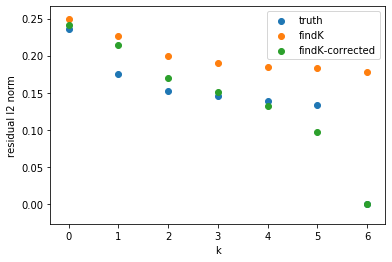

In [4]:
plt.scatter([i for i in range(k+1)], np.sqrt(diagR0))
plt.scatter([i for i in range(k+1)], np.sqrt(diagR1))
diagR2[np.isnan(diagR2)] = 0
plt.scatter([i for i in range(k+1)], np.sqrt(diagR2))
plt.legend(["truth", "findK", "findK-corrected"])
plt.xlabel("k")
plt.ylabel("residual l2 norm")
plt.show()

In [5]:
S0 = S0[:k]
S1 = S1[:k]
S2 = S2[:k]

print("S0")
print(S0)
print(vocab[S0.astype(int)])
print("S1")
print(S1)
print(vocab[S1.astype(int)])
print("S2")
print(S2)
print(vocab[S2.astype(int)])

S0
[1669 1888  178 1666  490 1933]
['"selects"' '"terms"' '"bayes"' '"selecting"' '"densities"' '"treated"']
S1
[ 245  463 2023  557 2051  719]
['"case"' '"curves"' '"volatility"' '"discriminant"' '"without"' '"fail"']
S2
[ 245.  463.  202. 1640. 1365. 2023.]
['"case"' '"curves"' '"biomedical"' '"satisfactory"' '"penalized"'
 '"volatility"']


S0


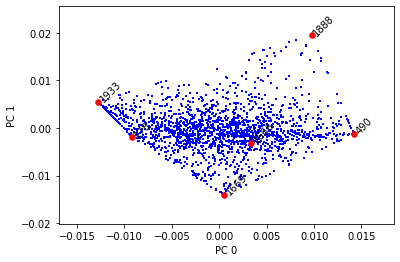

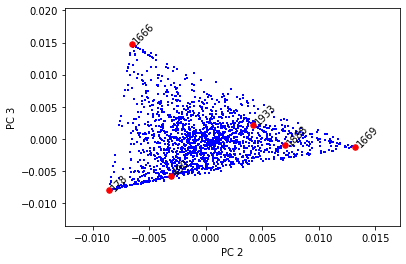

S1


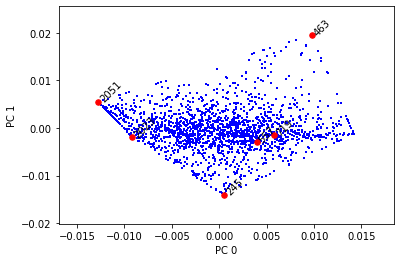

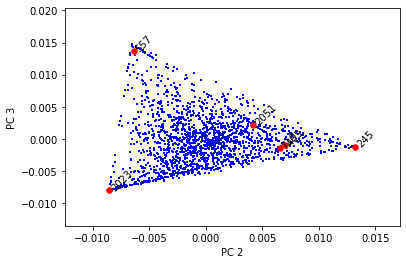

S2


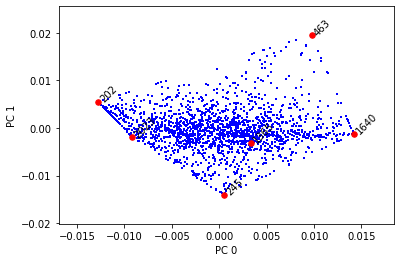

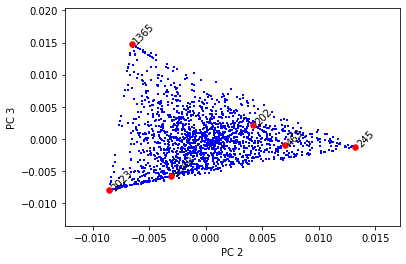

In [6]:
print("S0")
vis_extremal_pca(pca_proj(Cbar), S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S0.astype(int), [2, 3], annotate=True, fontsize=10)
print("S1")
vis_extremal_pca(pca_proj(Cbar), S1.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S1.astype(int), [2, 3], annotate=True, fontsize=10)
print("S2")
vis_extremal_pca(pca_proj(Cbar), S2.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S2.astype(int), [2, 3], annotate=True, fontsize=10)

## Investigate step 1

* Correction is very very helpful
* Sometimes some rare words (they are indeed anchor words) may happen to be very similar to more frequent anchor words. In that case, their variance is larger, thus more likely to be one with the largest l2 norm. 


Below I look at 3 anchor words for topic 1. The first is more frequent; the next 2 are rarer. I want to see how the corrected estimation for $||\bar{c}_j||^2$ (its histogram, and the empirical mean is yellow line) compared to truth (red line), and uncorrected estimate (empirical mean is green line)

[1.77295831e-03 9.87360819e-05 9.01503808e-05]


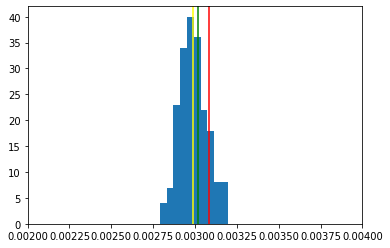

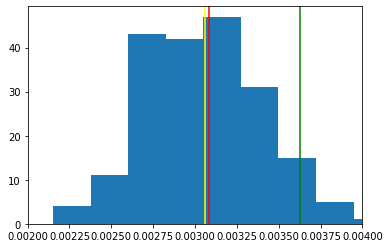

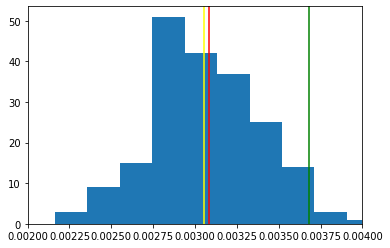

In [7]:
outputfile="findK-exper-step1.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
est_notcorrected = tmp['est_noncorrected']
truth = tmp['truth']
var = tmp['var']


idx_a1 = [1669,1728, 245]
print(C.sum(axis = 1)[idx_a1])

for j in idx_a1:
    plt.hist(est[j,:])
    plt.xlim((0.002, 0.004))
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est_notcorrected[j,:].mean(), color = "green")
    plt.show()

To see the effect of correction in general, compare the two plots below

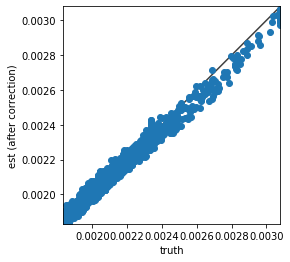

In [8]:
fig, ax = plt.subplots(1)
ax.scatter(truth, est.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est.mean(axis = 1).min(), est.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est (after correction)") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

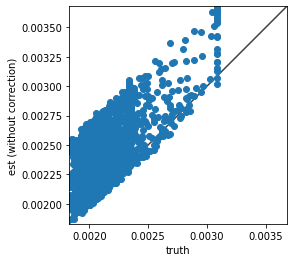

In [9]:
fig, ax = plt.subplots(1)
ax.scatter(truth, est_notcorrected.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est_notcorrected.mean(axis = 1).min(), est_notcorrected.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est (without correction)") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

Below is the mean and standard error of our estimator. 

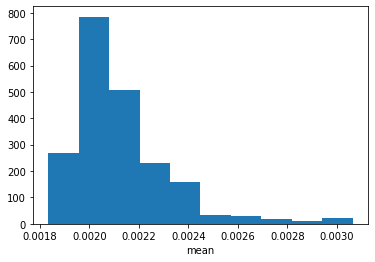

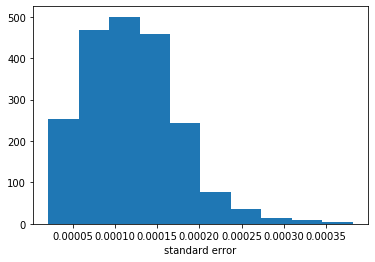

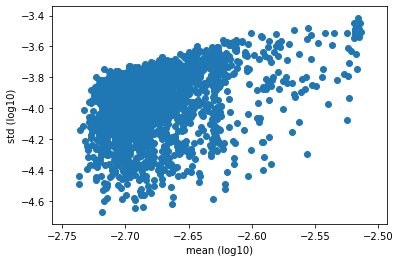

In [10]:
plt.hist(est.mean(axis = 1))
plt.xlabel("mean")
plt.show()

var_emp = ((est - est.mean(axis = 1)[:, None])**2).mean(axis = 1)
plt.hist(np.sqrt(var_emp))
plt.xlabel("standard error")
plt.show()

plt.scatter(np.log10(est.mean(axis = 1)), np.log10(np.sqrt(var_emp)))
plt.xlabel("mean (log10)")
plt.ylabel("std (log10)")
plt.show()

### document of equal length

Since for step 2 I find surprising result: estimation (without correction) becomes very good when documents have the same length. This does not happen here. 

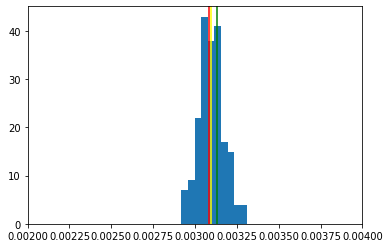

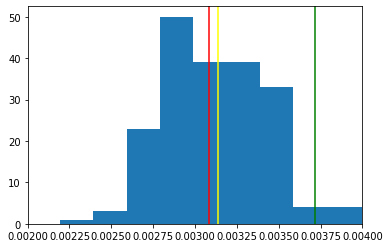

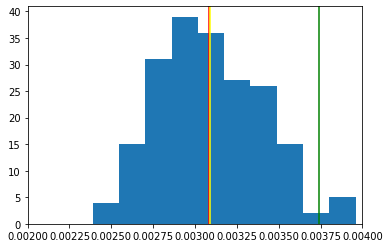

In [11]:
outputfile="findK-exper-step1-constd.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
est_noncorrected = tmp['est_noncorrected']
var = tmp['var']

for j in idx_a1:
    plt.hist(est[j,:])
    plt.xlim((0.002, 0.004))
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est_noncorrected[j,:].mean(), color = "green")
    plt.show()

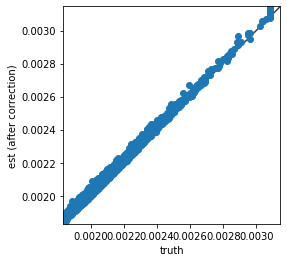

In [12]:
fig, ax = plt.subplots(1)
ax.scatter(truth, est.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est.mean(axis = 1).min(), est.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est (after correction)") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

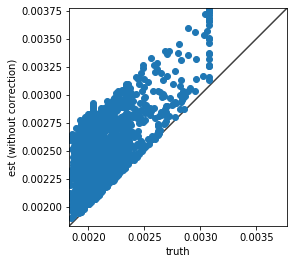

In [13]:
fig, ax = plt.subplots(1)
ax.scatter(truth, est_noncorrected.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est_noncorrected.mean(axis = 1).min(), est_noncorrected.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est (without correction)") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

### multiple anchor words

There are words that have basically the same $\bar{C}$ (TODO: see why). The rarer one more likely to have larger l2 norm, but its empirical estimate is worse. 

(1669, 1728)
(0.0017729583066349633, 9.873608193293289e-05)


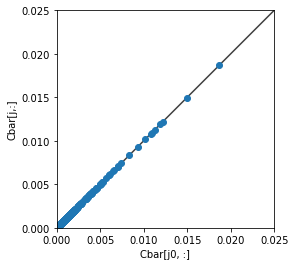

In [14]:
np.random.seed(123)
X = simulate_multinomial_counts_local(L, F, s)
C_ = compute_C_unbiased_local(X)
Cbar_ = C_ / C_.sum(axis = 1)[:, None]
j = np.argmax((Cbar_**2).sum(axis = 1))
j0 = np.argmax((Cbar**2).sum(axis = 1))

print((j0, j))
print((C[j0, :].sum(), C[j,:].sum())) 

fig, ax = plt.subplots(1)
ax.scatter(Cbar[j0,:], Cbar[j, :])
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar[j0, :]")
plt.ylabel("Cbar[j,:]")


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

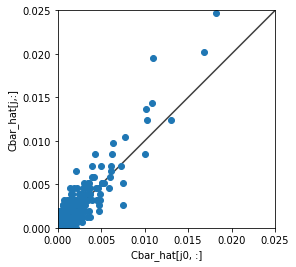

In [15]:
fig, ax = plt.subplots(1)
ax.scatter(Cbar_[j0,:], Cbar_[j, :])
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar_hat[j0, :]")
plt.ylabel("Cbar_hat[j,:]")


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

More frequent anchor word has much better estimate. 

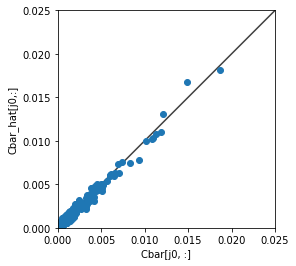

In [16]:
fig, ax = plt.subplots(1)
ax.scatter(Cbar[j0,:], Cbar_[j0, :])
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar[j0, :]")
plt.ylabel("Cbar_hat[j0,:]")


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

### Use averaging to improve estimates

It's natural to consider close-by words that have large l2 norm also as anchor words (juts not lucky enough in this realization to be the biggest).  


[1728  174 1669 1076  631]
['"single"' '"based"' '"selects"' '"like"' '"equality"']


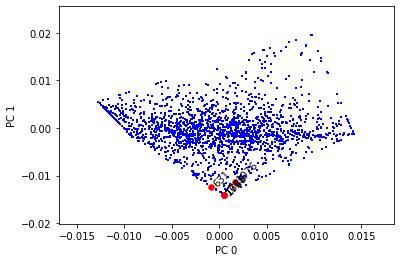

In [17]:
dist = ((Cbar_ - Cbar_[j,:][None,:])**2).sum(axis = 1)
idx = np.argsort(dist)
print(idx[:5])
print(vocab[idx[:5]])

vis_extremal_pca(pca_proj(Cbar), idx[:5], [0, 1], annotate=True, fontsize=10)

[7.72768308e-05 3.72859452e-04 1.62351734e-03 4.69890393e-03
 4.68135701e-04]
[0.00373936 0.00311748 0.00297891 0.00282438 0.00302416]


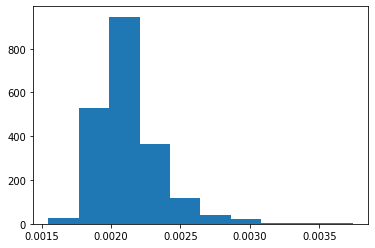

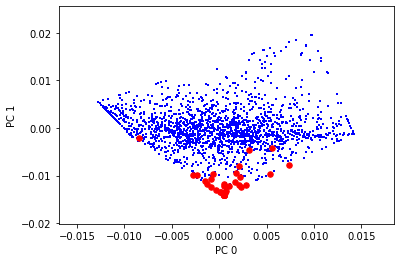

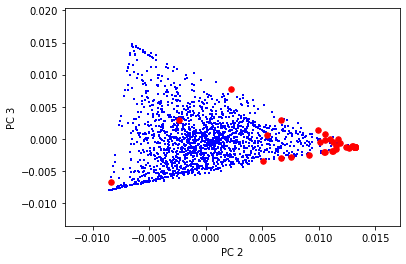

In [18]:
print(C_.sum(axis = 1)[idx[:5]])
weights = C_.sum(axis = 1)
const = 1 / (s**2 - s).sum()
rss_est ,_ = Cbar_rss(Cbar_, weights, const)
print(rss_est[idx[:5]])

plt.hist(rss_est)
plt.show()

idx2 = np.where(rss_est > 0.0028)[0]
vis_extremal_pca(pca_proj(Cbar), idx2, [0, 1], annotate=False, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), idx2, [2, 3], annotate=False, fontsize=10)

Below let's try using neighboring words to estimate anchor row better together. 

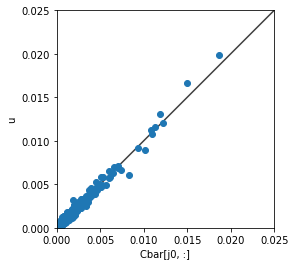

In [19]:
u = Cbar_[idx[:5],:].mean(axis = 0) ## think should use weighted sum

fig, ax = plt.subplots(1)
ax.scatter(Cbar[j0,:], u)
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar[j0, :]")
plt.ylabel("u") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Investigate step 2

Assume we can estimate the first anchor row well (using averaging), let's see how we estimate the second step. ($||(I - uu^T) \bar{c}_j||^2$). In fact we only need to look at estimate for $(u^T r_j)^2$

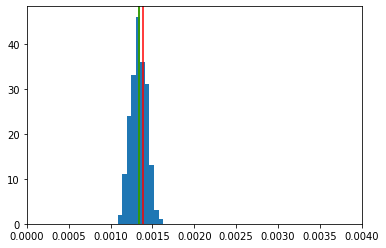

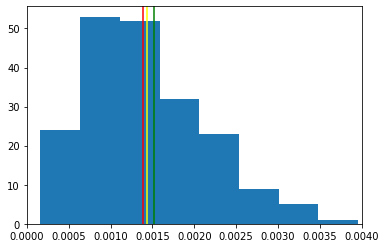

In [20]:
outputfile="findK-exper-step2-2.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

C = tmp["C"]
weights = C.sum(axis = 1)
est = tmp['est']/(weights**2)[:, None]
est_notcorrected = tmp['est_notcorrected']/(weights**2)[:, None]
truth = tmp['truth']/(weights**2)

# Cbar_true = tmp['C'] / tmp['C'].sum(axis = 1)[:, None]
# truth = ((tmp['u'][None, :] @ Cbar_true)**2)[0, :]

S0 = tmp['S0']
C = tmp['C']
u = tmp['u']


idx =   [S0[1], S2[1].astype(int)]

for j in idx:
    #print(u[j])
    plt.hist(est[j, :])
    plt.xlim((0, 0.004))
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est_notcorrected[j,:].mean(), color = "green")
    plt.show()

In [21]:
# for j in np.random.choice([i for i in range(est.shape[0])], 10):
#     print(u[j])
#     plt.hist(est[j, :])
#     plt.xlim((0, 0.006))
#     plt.axvline(x=truth[j], color = "red")
#     plt.axvline(x=est[j,:].mean(), color = "yellow")
#     plt.axvline(x=est_notcorrected[j,:].mean(), color = "green")
#     plt.show()

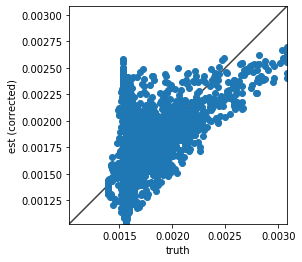

In [22]:
fig, ax = plt.subplots(1)

ax.scatter(truth, est.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est.mean(axis = 1).min(), est.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est (corrected)") 

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()


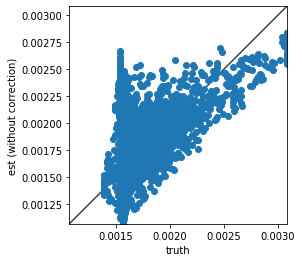

In [23]:
fig, ax = plt.subplots(1)
ax.scatter(truth, est_notcorrected.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est_notcorrected.mean(axis = 1).min(), est_notcorrected.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est (without correction)") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()



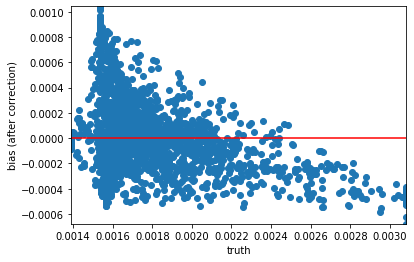

In [24]:
diff = est.mean(axis = 1) - truth
plt.scatter(truth, diff)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("truth")
plt.ylabel("bias (after correction)")
plt.xlim((truth.min(), truth.max()))
plt.ylim((diff.min(), diff.max()))
plt.show()

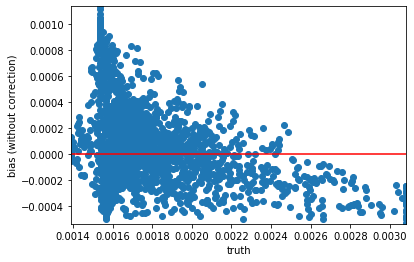

In [25]:
diff = est_notcorrected.mean(axis = 1) - truth
plt.scatter(truth, diff)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("truth")
plt.ylabel("bias (without correction)")
plt.xlim((truth.min(), truth.max()))
plt.ylim((diff.min(), diff.max()))
plt.show()

look at $u$

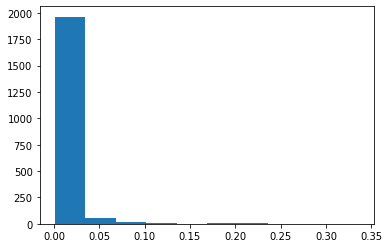

In [26]:
plt.hist(u)
plt.show()

## suppose all documents are of equal length

It surprises me the result is so much better, even without correction???? 

0.04108678077178281


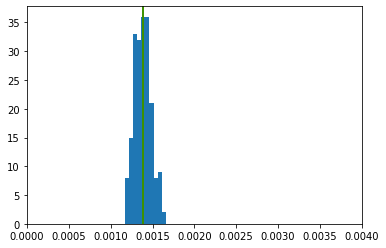

0.0009089991915911184


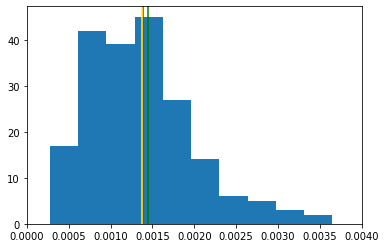

In [27]:
outputfile="findK-exper-step2-2-constd2.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

C = tmp["C"]
weights = C.sum(axis = 1)
est = tmp['est']/(weights**2)[:, None]
est_notcorrected = tmp['est_notcorrected']/(weights**2)[:, None]
truth = tmp['truth']/(weights**2)

# Cbar_true = tmp['C'] / tmp['C'].sum(axis = 1)[:, None]
# truth = ((tmp['u'][None, :] @ Cbar_true)**2)[0, :]

S0 = tmp['S0']
C = tmp['C']
u = tmp['u']


idx =   [S0[1], S2[1].astype(int)]

for j in idx:
    print(u[j])
    plt.hist(est[j, :])
    plt.xlim((0, 0.004))
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est_notcorrected[j,:].mean(), color = "green")
    plt.show()
    


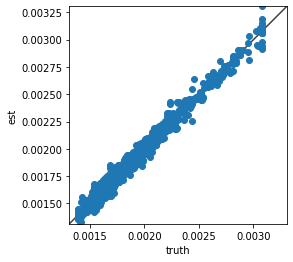

In [28]:
fig, ax = plt.subplots(1)

ax.scatter(truth, est.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est.mean(axis = 1).min(), est.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est") 

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()



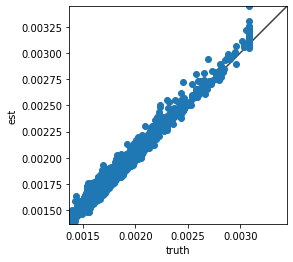

In [29]:
fig, ax = plt.subplots(1)

ax.scatter(truth, est_notcorrected.mean(axis = 1))
plt.xlim((truth.min(), truth.max()))
plt.ylim((est_notcorrected.mean(axis = 1).min(), est_notcorrected.mean(axis = 1).max()))
plt.xlabel("truth")
plt.ylabel("est") 

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

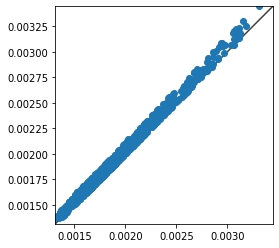

In [30]:
fig, ax = plt.subplots(1)
ax.scatter(est.mean(axis = 1), est_notcorrected.mean(axis = 1))
plt.xlim((est.mean(axis = 1).min(), est.mean(axis = 1).max()))
plt.ylim((est_notcorrected.mean(axis = 1).min(), est_notcorrected.mean(axis = 1).max()))

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

Below we can see the correction term still has an effect. 

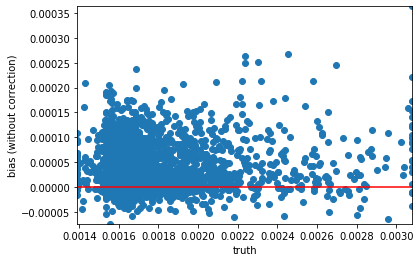

In [31]:
diff = est_notcorrected.mean(axis = 1) - truth
plt.scatter(truth, diff)
plt.axhline(y=0, color='r', linestyle='-')

plt.xlabel("truth")
plt.ylabel("bias (without correction)")
plt.xlim((truth.min(), truth.max()))
plt.ylim((diff.min(), diff.max()))
plt.show()

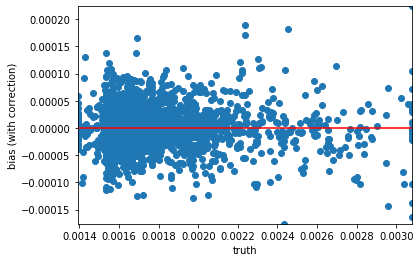

In [32]:
diff = est.mean(axis = 1) - truth
plt.scatter(truth, diff)
plt.axhline(y=0, color='r', linestyle='-')

plt.xlabel("truth")
plt.ylabel("bias (with correction)")
plt.xlim((truth.min(), truth.max()))
plt.ylim((diff.min(), diff.max()))
plt.show()

My first hypothesis is the topics are unbalanced. Some topics have many more words than others. Letting documents be equal length somehow makes topics balanced. But not the case. 

In [33]:
idx = np.argmax(F[S0, :], axis = 1) ## in the order of recovery
print((s[:, None] * L[:, idx]).sum(axis = 0))
print((s.mean() * L[:, idx]).sum(axis = 0))

[49706.4494874  27699.19354496 47102.0854192  42023.7882224
 37659.92405313 35841.50610155]
[51219.11742108 27600.40261028 46032.35426336 42082.1341055
 41537.18554515 31561.75288327]


### Thoughts

* It could be there should be a correction term that depends very much on the document lengths, not I made mistakes either in my computation or implementation. 

* But this gives me hope that we can estimate the second step well. 